<a href="https://colab.research.google.com/github/adildhkh/deep-learning/blob/main/style_transfer_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

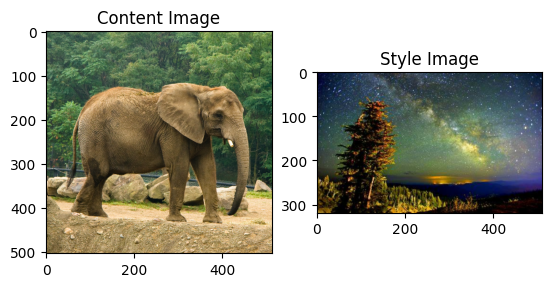

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Epochs:  10%|█         | 1/10 [00:13<02:00, 13.40s/it]

Epoch 1/10 completed


Epochs:  20%|██        | 2/10 [00:22<01:25, 10.72s/it]

Epoch 2/10 completed


Epochs:  30%|███       | 3/10 [00:31<01:09,  9.90s/it]

Epoch 3/10 completed


Epochs:  40%|████      | 4/10 [00:40<00:57,  9.56s/it]

Epoch 4/10 completed


Epochs:  50%|█████     | 5/10 [00:49<00:47,  9.41s/it]

Epoch 5/10 completed


Epochs:  60%|██████    | 6/10 [00:58<00:37,  9.35s/it]

Epoch 6/10 completed


Epochs:  70%|███████   | 7/10 [01:07<00:28,  9.34s/it]

Epoch 7/10 completed


Epochs:  80%|████████  | 8/10 [01:17<00:18,  9.36s/it]

Epoch 8/10 completed


Epochs:  90%|█████████ | 9/10 [01:26<00:09,  9.38s/it]

Epoch 9/10 completed


Epochs: 100%|██████████| 10/10 [01:36<00:00,  9.60s/it]

Epoch 10/10 completed
Total time: 96.05 seconds


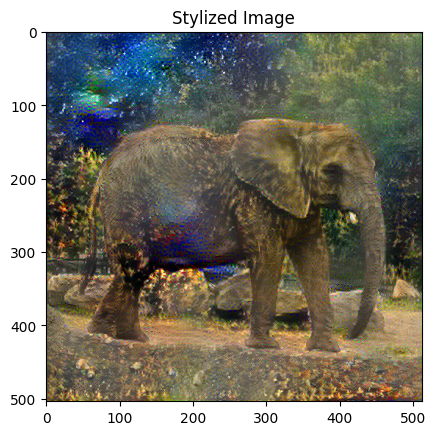

In [2]:
# Import necessary libraries
import tensorflow as tf
import numpy as np
import PIL.Image
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm for progress bar

# Load the content and style images
content_image_path = '/content/content.jpeg'
style_image_path = '/content/style.jpeg'

def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

content_image = load_img(content_image_path)
style_image = load_img(style_image_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')
plt.show()

# Load the VGG19 model
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

# Define the layers to use for style and content
content_layers = ['block5_conv2']
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

def vgg_layers(layer_names):
    """ Creates a VGG model that returns a list of intermediate output values."""
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

style_extractor = vgg_layers(style_layers)
content_extractor = vgg_layers(content_layers)

def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

        content_dict = {content_name: value
                        for content_name, value
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name: value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}

extractor = StyleContentModel(style_layers, content_layers)

style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

image = tf.Variable(content_image)

def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

optimizer = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

style_weight=1e-2
content_weight=1e4

def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)

    grad = tape.gradient(loss, image)
    optimizer.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

import time
start_time = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in tqdm(range(epochs), desc="Epochs"):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
  print(f"Epoch {n+1}/{epochs} completed")

end_time = time.time()
print(f"Total time: {end_time - start_time:.2f} seconds")

plt.imshow(image.read_value()[0])
plt.title("Stylized Image")
plt.show()